<div style="display: flex; gap: 10px;">
  <img src="../images/HOOPS_AI.jpg" style="width: 20%;">
   

# Fabwave - Part Classification using HOOPS AI

In this notebook, we preprocess a list of cadfiles for part classification.

in here:

- Gather a labeled dataset (fabave) located in the packages folder 
- Preprocess the cad files to be ML-input ready
- Preprocess the labels to be injected in the pipeline
- Create a dataset and dgl directories with the data ready for Training
- Train the ML model using the GraphClassification model

This is an example that only uses 4500 cadfiles. With 45 different part categories. 

In [1]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate=False)



ℹ️ Using TEST LICENSE (expires February 8th, 2026 - 12 days remaining)
   For production use, obtain your own license from Tech Soft 3D
HOOPS AI version :  1.0.0-b2dev9 



In [2]:
# Using a test flow name for 10-file test
from scripts.cad_tasks_fabwave import get_flow_name
flow_name = get_flow_name()
print(f"Flow name: {flow_name}")

HOOPS AI version :  1.0.0-b2dev9 

Flow name: ETL_Fabwave_training_b2


In [3]:
import os
import pathlib
from typing import Tuple, List

# Import the flow builder framework from the library
import hoops_ai
from hoops_ai.flowmanager import flowtask


from hoops_ai.cadaccess import HOOPSLoader, HOOPSTools
from hoops_ai.cadencoder import BrepEncoder
from hoops_ai.dataset import DatasetExplorer
from hoops_ai.storage import DataStorage, CADFileRetriever, LocalStorageProvider
from hoops_ai.storage.datasetstorage.schema_builder import SchemaBuilder

## Configuring Setup

In [4]:
# Configuration - Using simpler paths
nb_dir = pathlib.Path.cwd()
flows_outputdir = nb_dir.joinpath("out")
# Import task functions from external module for ProcessPoolExecutor compatibility
from scripts.cad_tasks_fabwave import gather_fabwave_files, encode_data_for_ml_training, my_workflow_for_fabewave, get_flow_name

## ETL Data pipeline


In [5]:
# data source
datasources_dir = [str(nb_dir.parent.joinpath("packages","cadfiles","fabwave"))
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD_1_15_Classes", "Bolts")),
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD_1_15_Classes", "Bushing_Damping_Liners")),
    #str(nb_dir.parent.joinpath("packages","cadfiles","fabwave", "CAD25-45_TOTAL1000", "Sleeve Washers"))   
                  ]

In [6]:
from display_utils import display_task_source
display_task_source(gather_fabwave_files, "gather_fabwave_files")

---

### `gather_fabwave_files`

```python
@flowtask.extract(
    name="gather fabwave files",
    inputs=["cad_datasources"],
    outputs=["cad_dataset"],
    parallel_execution=True
)
def gather_fabwave_files(source: str) -> List[str]:

    # Example 1: Basic retrieval with format filtering
    retriever = CADFileRetriever(
        storage_provider=LocalStorageProvider(directory_path=source),
        formats=[".stp", ".step", ".iges", ".igs"],
        #filter_pattern="*5*"  # Only files with "5" in name
    )
            
    # Get files using the library's retriever
    source_files = retriever.get_file_list()
    
    # Shuffle to get random sample instead of first N files in order
    import random
    random.seed(42)  # For reproducibility
    shuffled_files = source_files.copy()
    random.shuffle(shuffled_files)
    
    return shuffled_files #[:100]
```


In [7]:
labels_description = {
        0: {"name": "Bearings"              , "description": " fabewave dataset sample  "},
        1: {"name": "Bolts"                 , "description": " fabewave dataset sample  "},
        2: {"name": "Brackets"              , "description": " fabewave dataset sample  "},
        3: {"name": "Bushing"               , "description": " fabewave dataset sample  "},
        4: {"name": "Bushing_Damping_Liners", "description": " fabewave dataset sample  "},
        5: {"name": "Collets"               , "description": " fabewave dataset sample  "},
        6: {"name": "Gasket"                , "description": " fabewave dataset sample  "},
        7: {"name": "Grommets"              , "description": " fabewave dataset sample  "},
        8: {"name": "HeadlessScrews"        , "description": " fabewave dataset sample  "},
        9: {"name": "Hex_Head_Screws"       , "description": " fabewave dataset sample  "},
        10: {"name": "Keyway_Shaft"         , "description": " fabewave dataset sample  "},
        11: {"name": "Machine_Key"          , "description": " fabewave dataset sample  "},
        12: {"name": "Nuts"                 , "description": " fabewave dataset sample  "},
        13: {"name": "O_Rings"              , "description": " fabewave dataset sample  "},
        14: {"name": "Thumb_Screws"        , "description": " fabewave dataset sample   "},
        15: {"name": "Pipe_Fittings"        , "description": " fabewave dataset sample   "},
        16: {"name": "Pipe_Joints"              , "description": " fabewave dataset sample  "},
        17: {"name": "Pipes"                 , "description": " fabewave dataset sample  "},
        18: {"name": "Rollers"              , "description": " fabewave dataset sample  "},
        19: {"name": "Rotary_Shaft"               , "description": " fabewave dataset sample  "},
        20: {"name": "Shaft_Collar"         , "description": " fabewave dataset sample  "},
        21: {"name": "Slotted_Flat_Head_Screws"               , "description": " fabewave dataset sample  "},
        22: {"name": "Socket_Head_Screws"               , "description": " fabewave dataset sample  "},
        23: {"name": "Washers"                , "description": " fabewave dataset sample  "},
        24: {"name": "Boxes"              , "description": " fabewave dataset sample  "},
        25: {"name": "Cotter_Pin"        , "description": " fabewave dataset sample  "},
        26: {"name": "External Retaining Rings"       , "description": " fabewave dataset sample  "},
        27: {"name": "Eyesbolts With Shoulders"         , "description": " fabewave dataset sample  "},
        28: {"name": "Fixed Cap Flange"          , "description": " fabewave dataset sample  "},
        29: {"name": "Gear Rod Stock"                 , "description": " fabewave dataset sample  "},
        30: {"name": "Gears"              , "description": " fabewave dataset sample  "},
        31: {"name": "Holebolts With Shoulders"        , "description": " fabewave dataset sample   "},
        32: {"name": "Idler Sprocket"        , "description": " fabewave dataset sample   "},
        33: {"name": "Miter Gear Set Screw"        , "description": " fabewave dataset sample   "},
        34: {"name": "Miter Gears"        , "description": " fabewave dataset sample   "},
        35: {"name": "Rectangular Gear Rack"        , "description": " fabewave dataset sample   "},
        36: {"name": "Routing EyeBolts Bent Closed Eye"        , "description": " fabewave dataset sample   "},
        37: {"name": "Sleeve Washers"        , "description": " fabewave dataset sample   "},
        38: {"name": "Socket-Connect Flanges"        , "description": " fabewave dataset sample   "},
        39: {"name": "Sprocket Taper-Lock Bushing"        , "description": " fabewave dataset sample   "},
        40: {"name": "Strut Channel Floor Mount"        , "description": " fabewave dataset sample   "},
        41: {"name": "Strut Channel Side-Side"        , "description": " fabewave dataset sample   "},
        42: {"name": "Tag Holder"        , "description": " fabewave dataset sample   "},
        43: {"name": "Webbing Guide"        , "description": " fabewave dataset sample   "},
        44: {"name": "Wide Grip External Retaining Ring"        , "description": " fabewave dataset sample   "},
    }

# Invert the dictionary
description_to_code = {v["name"]: k for k, v in labels_description.items()}

# Data Transformation : Encoded data to be used as ml input

In [8]:
display_task_source(encode_data_for_ml_training, "encode_data_for_ml_training")

---

### `encode_data_for_ml_training`

```python
@flowtask.transform(
    name="Preparing data for Exploring and ML training",
    inputs=["cad_dataset"],
    outputs=["cad_files_encoded"],
    parallel_execution=True
)
def encode_data_for_ml_training(cad_file: str, cad_loader :  HOOPSLoader, storage : DataStorage) -> str:
    import numpy as np
    import random

    cad_model = cad_loader.create_from_file(cad_file)
    storage.set_schema(cad_schema)

    facecount, edgecount = my_workflow_for_fabewave.encode_cad_data(cad_file, cad_loader, storage)
    
    # Add label data
    folder_with_name = str(pathlib.Path(cad_file).parent.parent.stem)
    label_code = description_to_code.get(folder_with_name, None)
    
    # Validate label_code - skip if unknown category
    if label_code is None:
        raise ValueError(f"Unknown category '{folder_with_name}' for file {cad_file}. Category not found in labels_description.")
    
    label_description = [{int(label_code) : labels_description[label_code]["name"]} ]
    
    # Save label data in the schema-defined group for dataset analytics
    storage.save_data("Labels/part_label", np.array([label_code]))
    storage.save_metadata("part_label_description", folder_with_name)
    
    # ALSO save label using the key expected by GraphClassification.convert_encoded_data_to_graph
    # This is required for the DGL graph files to have the correct labels
    storage.save_data(LabelStorage.GRAPH_CADENTITY, np.array([label_code]))
    
    #my_workflow_for_fabewave.encode_label_data()
    dgl_storage = DGLGraphStoreHandler()

    # DGL graph Bin file
    item_no_suffix = pathlib.Path(cad_file).with_suffix("")  # Remove the suffix to get the base name
    hash_id = generate_unique_id_from_path(str(item_no_suffix))
    dgl_output_path = pathlib.Path(flows_outputdir).joinpath("flows", flow_name, "dgl", f"{hash_id}.ml")  
    dgl_output_path.parent.mkdir(parents=True, exist_ok=True)

    my_workflow_for_fabewave.convert_encoded_data_to_graph(storage, dgl_storage, str(dgl_output_path))
    
    # Save file-level metadata (will be routed to .infoset)
    storage.save_metadata("Item", str(cad_file))
    storage.save_metadata("source", "FABWAVE")
    
    # Compress the storage into a .data file
    storage.compress_store()
    
    # Return the base storage path
    return storage.get_file_path("")
```


## Pipeline execution

In [9]:
# Create and run the Data Flow
flow_name = get_flow_name()
cad_flow = hoops_ai.create_flow(
    name=flow_name,
    tasks=[gather_fabwave_files, encode_data_for_ml_training],
    max_workers=50,
    flows_outputdir=str(flows_outputdir),
    ml_task="Part Classification",
    #debug = True,
    auto_dataset_export=True,  # Enable automatic dataset merging
    export_visualization=False  # Disable visualization export
)

# Run the flow to process all files
print("Starting flow execution with parallel processing...")
flow_output, output_dict, flow_file = cad_flow.process(inputs={'cad_datasources': datasources_dir}, clean_ouput_dir = False)

# Display results
print("\n" + "="*70)
print("FLOW EXECUTION COMPLETED SUCCESSFULLY")
print("="*70)
print(f"\nDataset files created:")
print(f"  Main dataset: {output_dict.get('flow_data', 'N/A')}")
print(f"  Info dataset: {output_dict.get('flow_info', 'N/A')}")
print(f"  Attributes: {output_dict.get('flow_attributes', 'N/A')}")
print(f"  Flow file: {flow_file}")
print(f"\nTotal processing time: {output_dict.get('Duration [seconds]', {}).get('total', 0):.2f} seconds")
print(f"Files processed: {output_dict.get('file_count', 0)}")


Starting flow execution with parallel processing...
|INFO| FLOW | ######### Flow 'ETL_Fabwave_training_b2' start #######
|INFO| FLOW | 
Flow Execution Summary
|INFO| FLOW | ==================================================
|INFO| FLOW | Task 1: gather fabwave files
|INFO| FLOW |     Inputs : cad_datasources
|INFO| FLOW |     Outputs: cad_dataset
|INFO| FLOW | Task 2: Preparing data for Exploring and ML training
|INFO| FLOW |     Inputs : cad_dataset
|INFO| FLOW |     Outputs: cad_files_encoded
|INFO| FLOW | Task 3: AutoDatasetExportTask
|INFO| FLOW |     Inputs : cad_files_encoded
|INFO| FLOW |     Outputs: encoded_dataset, encoded_dataset_info, encoded_dataset_attribs
|INFO| FLOW | 
Task Dependencies:
|INFO| FLOW | gather fabwave files has no dependencies.
|INFO| FLOW | gather fabwave files --> Preparing data for Exploring and ML training
|INFO| FLOW | Preparing data for Exploring and ML training --> AutoDatasetExportTask
|INFO| FLOW | ================================================

DATA INGESTION:   0%|                                                                            | 0/1 [00:00<…

|INFO| FLOW | Executing ParallelTask 'Preparing data for Exploring and ML training' with 4572 items.


DATA TRANSFORMATION:   0%|                                                                    | 0/4572 [00:00<…

|WARNING| FLOW | Total number of items with errors: 26 (0.57%)
|WARNING| FLOW | Corrupted items are listed in 'C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\error_summary.json'.
|INFO| FLOW | Executing SequentialTask 'AutoDatasetExportTask'.
Sequential Task end=====================
|INFO| FLOW | Time taken: 50.96 seconds
|INFO| FLOW | ######### Flow 'ETL_Fabwave_training_b2' end ######

FLOW EXECUTION COMPLETED SUCCESSFULLY

Dataset files created:
  Main dataset: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\ETL_Fabwave_training_b2.dataset
  Info dataset: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\ETL_Fabwave_training_b2.infoset
  Attributes: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2\ETL_Fabwave_training_b2.attr

## Data Serving : Analytics

In [10]:
# Explore the generated dataset
explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:64205' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/4486 [00:00<?, ?it/s]


--- Dataset Table of Contents ---

LABELS_GROUP:
  FILE_ID_CODE_LABELS_DATA: Shape: (4536,), Dims: ('Labels_part_label_dim_0',), Size: 4536
  PART_LABEL_DATA: Shape: (4536,), Dims: ('Labels_part_label_dim_0',), Size: 4536

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_INDICES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_LENGTHS_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_TYPES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_U_GRIDS_DATA: Shape: (313252, 10, 6), Dims: ('edge', 'dim_x', 'component'), Size: 18795120
  FILE_ID_CODE_EDGES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252

FACE_MESH_GROUP:
  FACE_MESH_ADJ_DATA: Shape: (121444, 10000), Dims: ('face', 'component'), Size: 1214440000
  FILE_ID_CODE_FACE_MESH_DATA: Shape: (121444,), Dims: ('face',), Size: 121444

FACES_GROUP:
  FACE_AREAS_DATA: Shape: (12144

## ML-Ready Dataset Preparation

The `DatasetLoader` provides tools for preparing the merged dataset for machine learning:

### Key Capabilities:
- **Stratified Splitting**: Create train/validation/test splits while preserving class distributions
- **Subset Tracking**: Records file assignments in the dataset metadata

In [11]:
print(explorer.available_groups())

{'face_mesh', 'faces', 'graph', 'edges', 'Labels'}


In [12]:
print(explorer.available_arrays('Labels'))

{'part_label', 'file_id_code_Labels'}


In [13]:
# Visualization libraries
import matplotlib.pyplot as plt

def print_distribution_info(dist, title="Distribution"):
    """Helper function to print and visualize distribution data."""
    list_filecount = list()
    for i, bin_files in enumerate(dist['file_id_codes_in_bins']):
        list_filecount.append(bin_files.size)

    dist['file_count'] =list_filecount
    # Visualization with matplotlib
    fig, ax = plt.subplots(figsize=(12, 4))
    
    bin_centers = 0.5 * (dist['bin_edges'][1:] + dist['bin_edges'][:-1])
    ax.bar(bin_centers, dist['file_count'], width=(dist['bin_edges'][1] - dist['bin_edges'][0]), 
           alpha=0.7, color='steelblue', edgecolor='black', linewidth=1)
    
    # Add file count annotations
    for i, count in enumerate(dist['file_count']):
        if count > 0:  # Only annotate non-empty bins
            ax.text(bin_centers[i], count + 0.5, f"{count}", 
                    ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(f'{title} Histogram')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

Material distribution created in 1.98 seconds



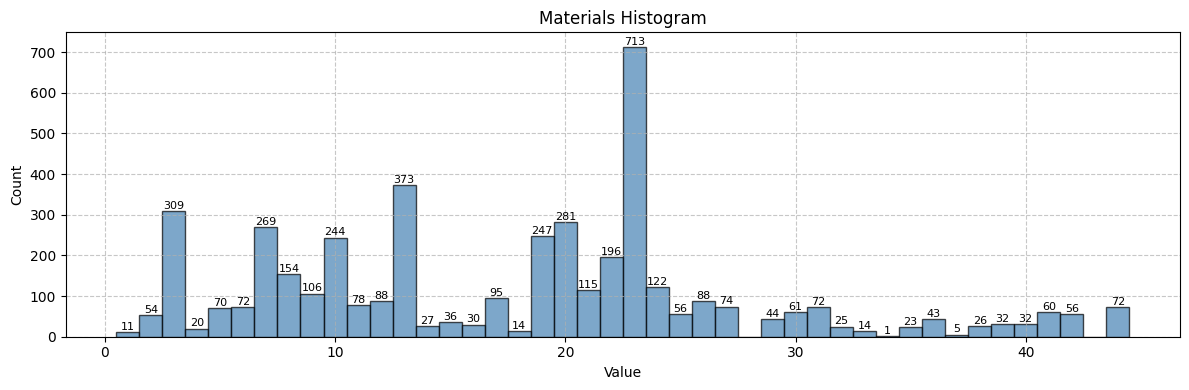

In [14]:
import time
start_time = time.time()
face_dist = explorer.create_distribution(key="part_label", bins=None, group="Labels")
print(f"Material distribution created in {(time.time() - start_time):.2f} seconds\n")
print_distribution_info(face_dist, title="Materials")

## Dataset Visualization with DatasetViewer

The **DatasetViewer** is a powerful visualization tool that bridges dataset queries and visual analysis. It enables you to quickly visualize query results in two ways:

1. **Image Grids**: Generate collages of PNG previews for rapid visual scanning
2. **Interactive 3D Views**: Open inline 3D viewers for detailed model inspection

In [15]:
# Import the DatasetViewer from the insights module
from hoops_ai.insights import DatasetViewer

# Create a DatasetViewer using the convenience method from_explorer
# This method queries the explorer and builds the file ID to visualization path mappings
dataset_viewer = DatasetViewer.from_explorer(explorer)

2026-01-26 23:49:57 | INFO | hoops_ai.insights.dataset_viewer | Initialized process pool with 4 workers
2026-01-26 23:49:57 | INFO | hoops_ai.insights.dataset_viewer | DatasetViewer initialized with reference directory: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training_b2
2026-01-26 23:49:57 | INFO | hoops_ai.insights.dataset_viewer | Built file mapping for 635 files


In [16]:
start_time = time.time()

# condition
material_is_frequent = lambda ds: ds['part_label'] == 23

filelist = explorer.get_file_list(group="Labels", where=material_is_frequent)
print(f"Filtering completed in {(time.time() - start_time):.2f} seconds")
print(len(filelist))

Filtering completed in 0.34 seconds
712


### Example 1: Visualize Query Results as Image Grid

Now let's use the query results we obtained earlier and visualize them as a grid of images. This is perfect for quickly scanning through many files to understand patterns or identify specific cases.

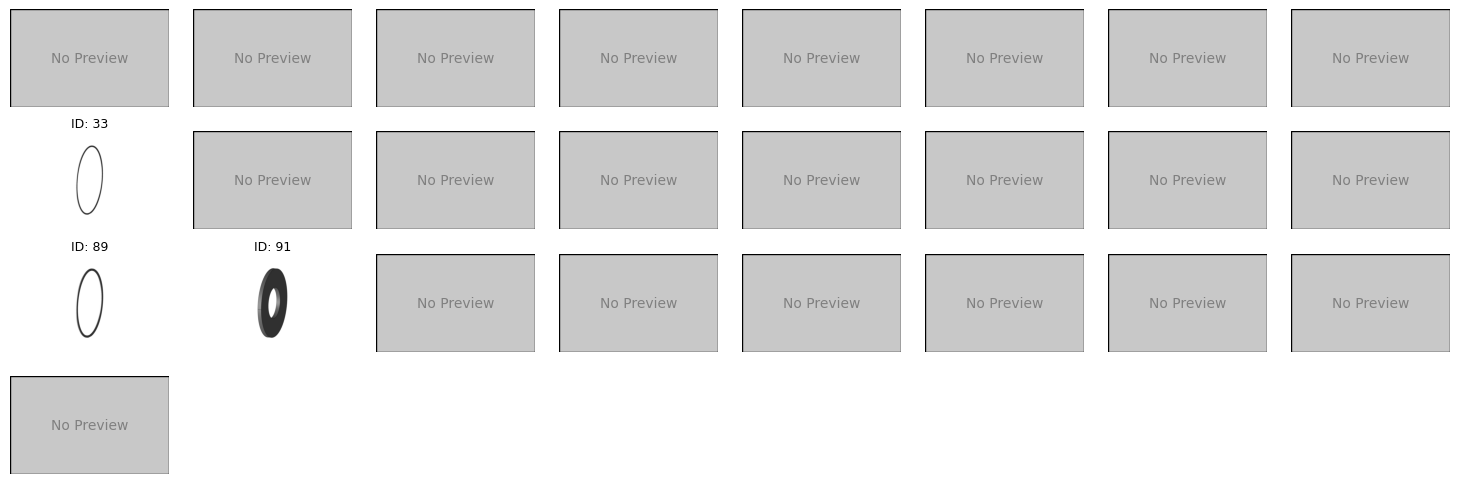

In [17]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    filelist, 
    k=25,                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    label_format='id',         # Show file IDs as labels
    figsize=(15, 5)           # Larger figure size
)

plt.show()

# Machine Learning Training

In [18]:
# Load and split dataset for machine learning
from hoops_ai.dataset import DatasetLoader

flow_path = pathlib.Path(flow_file)
loader = DatasetLoader(
    merged_store_path=str(flow_path.parent / f"{flow_path.stem}.dataset"),  
    parquet_file_path=str(flow_path.parent / f"{flow_path.stem}.infoset")
)

# Split dataset by machining category with explicit group parameter
train_size, val_size, test_size = loader.split(
    key="part_label",
    group="Labels",  # Explicitly specify the group for clarity
    train=0.6, 
    validation=0.2, 
    test=0.2, 
    random_state=42
)

print(f"Dataset split: Train={train_size}, Validation={val_size}, Test={test_size}")

# Access training dataset
train_dataset = loader.get_dataset("train")
print(f"Training dataset ready with {len(train_dataset)} samples")

[DatasetExplorer] Default local cluster started: <Client: 'tcp://127.0.0.1:59524' processes=1 threads=16, memory=7.45 GiB>


Processing file info:   0%|          | 0/4486 [00:00<?, ?it/s]

DEBUG: Successfully built file lists with 4486 files out of 4486 original file codes

DATASET STRUCTURE OVERVIEW

Group: Labels
------------------------------
  file_id_code_Labels: (4536,) (int64)
  part_label: (4536,) (float64)

Group: edges
------------------------------
  edge_convexities: (313252,) (int32)
  edge_dihedral_angles: (313252,) (float32)
  edge_indices: (313252,) (int32)
  edge_lengths: (313252,) (float32)
  edge_types: (313252,) (int32)
  edge_u_grids: (313252, 10, 6) (float32)
  file_id_code_edges: (313252,) (int64)

Group: face_mesh
------------------------------
  face_mesh_adj: (121444, 10000) (float32)
  file_id_code_face_mesh: (121444,) (int64)

Group: faces
------------------------------
  face_areas: (121444,) (float32)
  face_discretization: (121444, 100, 7) (float32)
  face_indices: (121444,) (int32)
  face_loops: (121444,) (int32)
  face_types: (121444,) (int32)
  file_id_code_faces: (121444,) (int64)

Group: graph
------------------------------
  edges_des

In [19]:
from hoops_ai.ml.EXPERIMENTAL import FlowTrainer


flow_root_dir = nb_dir.joinpath("out","flows","ETL_Fabwave_training")

In [20]:
flow_trainer = FlowTrainer(

    flowmodel       = my_workflow_for_fabewave,
    datasetLoader   = loader,
    experiment_name = "HOOPS_AI_train",
    result_dir      = flow_root_dir,
    accelerator     = 'cuda', # for gpu 'cuda'
    devices         = [0],     # use [0] or [1] for gpu
    max_epochs      = 1,
    batch_size      = 64
    )

GRAPH CLASSIFICATION - HOOPS GAT - MODEL


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [21]:
trained_model_path = flow_trainer.train()
print(f"Training finished. Model checkpoint saved in {trained_model_path}")


-----------------------------------------------------------------------------------
GRAPH CLASSIFICATION - HOOPS GAT - MODEL - TRAINING STEP
-----------------------------------------------------------------------------------
Training batch size               : 64
Adjusted learning rate (for batch): 0.002

Train set contains                : 2692 samples (60.01%)
Validation set contains           : 897 samples (20.00%)
Test set contains                 : 897 samples (20.00%)
Total samples                     : 4486
Max Epoch                         : 1

The trained model: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0126\235008\best.ckpt

To monitor the logs, run:
tensorboard --logdir results/HOOPS_AI_train/0126/235008
-----------------------------------------------------------------------------------
        


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Training finished. Model checkpoint saved in C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0126\235008\best.ckpt


In [22]:
## Testing phase
flow_trainer.test(trained_model_path)
print(f"Testing finished")

Restoring states from the checkpoint path at C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0126\235008\best.ckpt



-----------------------------------------------------------------------------------
GRAPH CLASSIFICATION - HOOPS GAT - MODEL - TESTING STEP
-----------------------------------------------------------------------------------

The trained model: C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0126\235008\best.ckpt

Test set contains 897 training samples
-----------------------------------------------------------------------------------
        


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at C:\Users\LuisSalazar\Documents\MAIN\MLProject\repo\HOOPS-AI-tutorials\notebooks\out\flows\ETL_Fabwave_training\ml_output\HOOPS_AI_train\0126\235008\best.ckpt


Testing: 0it [00:00, ?it/s]

Number of classes: 45
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           IoU              0.21895338830822703
    overall_accuracy        0.2410714328289032
   per_class_accuracy       0.10227096080780029
        test_acc            0.2410714328289032
        test_loss            2.643768787384033
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing finished


In [23]:
#explorer = DatasetExplorer(flow_output_file=str(flow_file))
explorer.print_table_of_contents()


--- Dataset Table of Contents ---

LABELS_GROUP:
  FILE_ID_CODE_LABELS_DATA: Shape: (4536,), Dims: ('Labels_part_label_dim_0',), Size: 4536
  PART_LABEL_DATA: Shape: (4536,), Dims: ('Labels_part_label_dim_0',), Size: 4536

EDGES_GROUP:
  EDGE_CONVEXITIES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_DIHEDRAL_ANGLES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_INDICES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_LENGTHS_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_TYPES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252
  EDGE_U_GRIDS_DATA: Shape: (313252, 10, 6), Dims: ('edge', 'dim_x', 'component'), Size: 18795120
  FILE_ID_CODE_EDGES_DATA: Shape: (313252,), Dims: ('edge',), Size: 313252

FACE_MESH_GROUP:
  FACE_MESH_ADJ_DATA: Shape: (121444, 10000), Dims: ('face', 'component'), Size: 1214440000
  FILE_ID_CODE_FACE_MESH_DATA: Shape: (121444,), Dims: ('face',), Size: 121444

FACES_GROUP:
  FACE_AREAS_DATA: Shape: (12144

In [24]:
test_dataset = loader.get_dataset("test")
file_list = test_dataset.indices[:50]
print(file_list)

[  3   4   9  13  15  16  20  37  40  46  49  56  60  67  78  81  86  90
  94  95  98 103 110 111 119 121 123 130 135 146 160 172 176 181 187 193
 194 198 200 206 213 214 217 221 231 232 237 253 259 262]


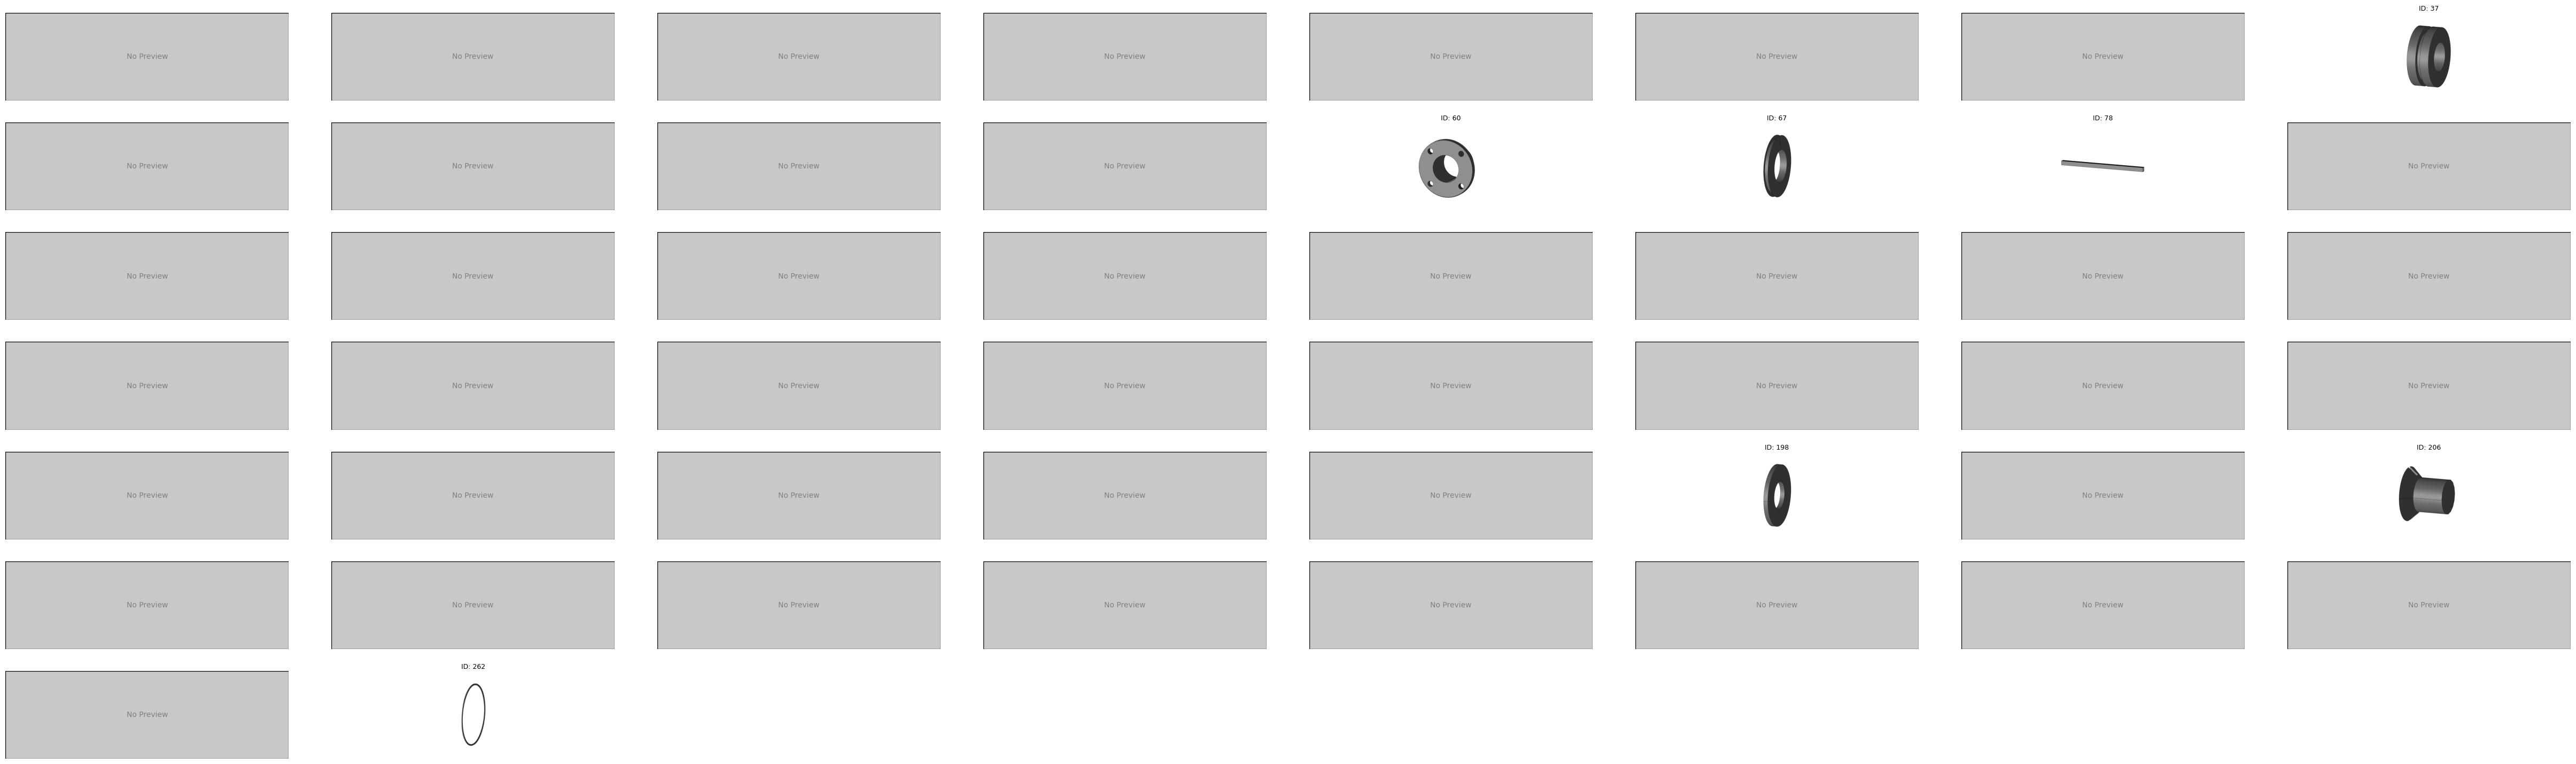

In [25]:
# Visualize the filtered files as a 5x5 grid with file IDs as labels
fig = dataset_viewer.show_preview_as_image(
    file_list, 
    k=len(file_list),                      # Show up to 25 files
    grid_cols=8,               # 5 columns
    figsize=(50, 15)           # Larger figure size
)

plt.show()